<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/tab_hoarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tab Hoarding  
Everyone has a friend (it might be them) who opens a bunch of tabs and when they look at their browser the tabs at the top of the tab navigation are so tiny that you can't even see the title of the web pages. Who would do that? Who would do such a thing?  

I would. Me, Nick Wan. But also, apparently a lot of people. So this notebook and subsequent data should investigate the extent to which we can call someone a "tab hoarder" -- someone who opens a lot of tabs in their browser and does not close tabs after they are done using them or perhaps practices opening links "to save for later" but tends to not return to those "save for later" tabs.  

If this sounds like you, well, there might be a lot of you. So it might not be that bad.

## Load in

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from scipy.stats import ttest_ind, ttest_rel, ttest_ind_from_stats, ttest_1samp

from google.colab import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
fn = 'tab_hoarding (Responses)'
worksheet = gc.open(fn).sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.loc[0].str.rstrip()
df = df.drop(0).reset_index(drop=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

for col in ['How often do you work with data (organized values in something like a spreadsheet, CSV, database, etc)?','How long have you been working with data?']:
  df[col] = df[col].astype('category')
  df[f"{col}_code"] = df[col].cat.codes

for col in ['How many tabs do you have open right now', 'On average, how many tabs do you have open?','What is your age?']:
  df[col] = df[col].astype(float).round().astype(int)

for col in ['Do you believe people typically have more tabs open than you do?', 'Would you consider your current job in the STEM field?']:
  df[col] = df[col].str.replace('Yes','1').str.replace('No','0').astype(int).astype(bool)

df.shape

(273, 11)

## Describe the dataset


In [ ]:
df.sample(10)

,Timestamp,"How often do you work with data (organized values in something like a spreadsheet, CSV, database, etc)?",How long have you been working with data?,How many tabs do you have open right now,"On average, how many tabs do you have open?",Do you believe people typically have more tabs open than you do?,Would you consider your current job in the STEM field?,What is your job title?,What is your age?,"How often do you work with data (organized values in something like a spreadsheet, CSV, database, etc)?_code",How long have you been working with data?_code
252,2020-07-11 20:56:07,1-4 hours a day,1-4 years,6,4,False,False,Part Time Scout NY Mets,20,0,0
230,2020-06-19 18:26:55,1-4 hours a day,1-4 years,28,15,True,False,Marketing Analyst,25,0,0
59,2020-06-18 02:04:14,>8 hours a day,>8 years,1,4,True,True,Postdoctoral researcher,38,3,3
62,2020-06-18 04:06:17,<1 a day,>8 years,35,30,False,True,Research Associate,34,2,3
202,2020-06-18 20:58:51,1-4 hours a day,4-8 years,6,8,False,True,Actuary,30,0,1
124,2020-06-18 12:16:01,1-4 hours a day,>8 years,50,80,False,True,Professor,37,0,3
251,2020-07-11 16:30:14,4-8 hours a day,>8 years,0,4,False,True,Assistant Professor,31,1,3
157,2020-06-18 18:26:57,1-4 hours a day,>8 years,5,8,False,True,Sports Data Analyst,40,0,3
149,2020-06-18 18:12:56,>8 hours a day,4-8 years,12,5,True,True,Analyst,26,3,1
32,2020-06-18 00:09:26,4-8 hours a day,4-8 years,14,8,True,True,Senior Data Analyst,29,1,1


In [ ]:
x = df['How many tabs do you have open right now'].value_counts()

qualified = x[x>1].index.values

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


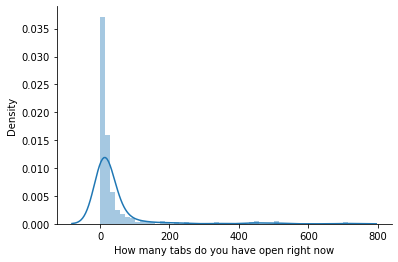

,How many tabs do you have open right now
count,273.000000
mean,36.003663
std,83.109933
min,0.000000
25%,6.000000
50%,13.000000
75%,28.000000
max,715.000000


In [ ]:
sns.distplot(df['How many tabs do you have open right now'])
sns.despine()
plt.show()
df.loc[:,['How many tabs do you have open right now']].describe()

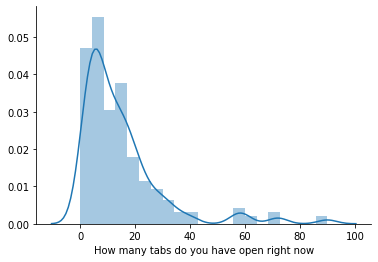

count    223.000000
mean      14.730942
std       15.191845
min        0.000000
25%        5.000000
50%       11.000000
75%       18.000000
max       90.000000
Name: How many tabs do you have open right now, dtype: float64

In [ ]:
sns.distplot(df.loc[df['How many tabs do you have open right now'].isin(qualified),'How many tabs do you have open right now'])
sns.despine()
plt.show()
df.loc[df['How many tabs do you have open right now'].isin(qualified),'How many tabs do you have open right now'].describe()

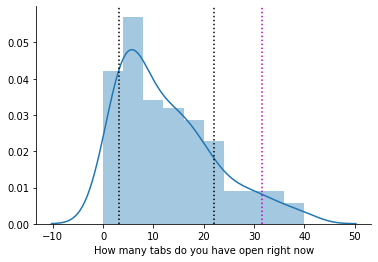

count    219.000000
mean      12.557078
std        9.479586
min        0.000000
25%        5.000000
50%       10.000000
75%       18.000000
max       40.000000
Name: How many tabs do you have open right now, dtype: float64

In [ ]:
col = 'How many tabs do you have open right now'
sns.distplot(df.loc[df[col]<=40,col])
plt.axvline(df.loc[df[col]<=40,col].mean()+(2*df.loc[df[col]<=40,col].std()),c='m',ls=':')
plt.axvline(df.loc[df[col]<=40,col].mean()+df.loc[df[col]<=40,col].std(),c='k',ls=':')
plt.axvline(df.loc[df[col]<=40,col].mean()-df.loc[df[col]<=40,col].std(),c='k',ls=':')
sns.despine()
plt.show()
df.loc[df[col]<=40,col].describe()


In [ ]:
df.loc[df[col]<=40,'How many tabs do you have open right now'].value_counts()

3     18
5     17
6     15
8     11
16    10
7     10
12    10
1      9
13     9
20     9
2      8
17     8
4      8
10     7
22     6
18     6
11     6
9      6
15     6
32     4
26     4
14     3
40     3
23     3
28     3
35     3
21     2
25     2
29     2
30     2
0      2
39     1
19     1
24     1
27     1
31     1
34     1
37     1
Name: How many tabs do you have open right now, dtype: int64

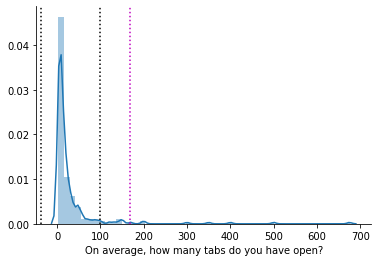

count    263.000000
mean      30.692015
std       68.340416
min        2.000000
25%        6.000000
50%       10.000000
75%       25.000000
max      675.000000
Name: On average, how many tabs do you have open?, dtype: float64

In [ ]:
col = 'On average, how many tabs do you have open?'
sns.distplot(df.loc[:,col])
plt.axvline(df.loc[:,col].mean()+(2*df.loc[:,col].std()),c='m',ls=':')
plt.axvline(df.loc[:,col].mean()+df.loc[:,col].std(),c='k',ls=':')
plt.axvline(df.loc[:,col].mean()-df.loc[:,col].std(),c='k',ls=':')
sns.despine()
plt.show()
df.loc[:,col].describe()


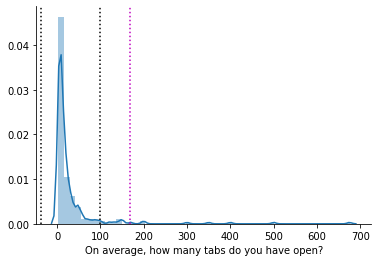

count    263.000000
mean      30.692015
std       68.340416
min        2.000000
25%        6.000000
50%       10.000000
75%       25.000000
max      675.000000
Name: On average, how many tabs do you have open?, dtype: float64

In [ ]:
col = 'On average, how many tabs do you have open?'
sns.distplot(df.loc[:,col])
plt.axvline(df.loc[:,col].mean()+(2*df.loc[:,col].std()),c='m',ls=':')
plt.axvline(df.loc[:,col].mean()+df.loc[:,col].std(),c='k',ls=':')
plt.axvline(df.loc[:,col].mean()-df.loc[:,col].std(),c='k',ls=':')
sns.despine()
plt.show()
df.loc[:,col].describe()


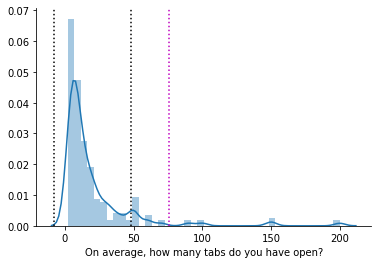

count    246.000000
mean      20.040650
std       28.016438
min        2.000000
25%        5.000000
50%       10.000000
75%       20.000000
max      200.000000
Name: On average, how many tabs do you have open?, dtype: float64

In [ ]:
col = 'On average, how many tabs do you have open?'

x = df[col].value_counts()
qualified = x[x>1].index.values

sns.distplot(df.loc[df[col].isin(qualified),col])
plt.axvline(df.loc[df[col].isin(qualified),col].mean()+(2*df.loc[df[col].isin(qualified),col].std()),c='m',ls=':')
plt.axvline(df.loc[df[col].isin(qualified),col].mean()+df.loc[df[col].isin(qualified),col].std(),c='k',ls=':')
plt.axvline(df.loc[df[col].isin(qualified),col].mean()-df.loc[df[col].isin(qualified),col].std(),c='k',ls=':')
sns.despine()
plt.show()
df.loc[df[col].isin(qualified),col].describe()

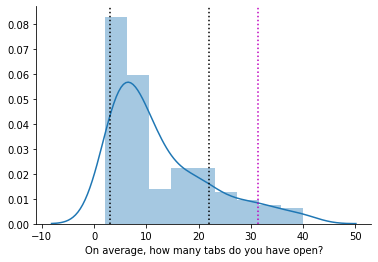

count    223.000000
mean      12.542601
std        9.417098
min        2.000000
25%        5.000000
50%       10.000000
75%       18.000000
max       40.000000
Name: On average, how many tabs do you have open?, dtype: float64

In [ ]:
col = 'On average, how many tabs do you have open?'
sns.distplot(df.loc[df[col]<=40,col])
plt.axvline(df.loc[df[col]<=40,col].mean()+(2*df.loc[df[col]<=40,col].std()),c='m',ls=':')
plt.axvline(df.loc[df[col]<=40,col].mean()+df.loc[df[col]<=40,col].std(),c='k',ls=':')
plt.axvline(df.loc[df[col]<=40,col].mean()-df.loc[df[col]<=40,col].std(),c='k',ls=':')
sns.despine()
plt.show()
df.loc[df[col]<=40,col].describe()


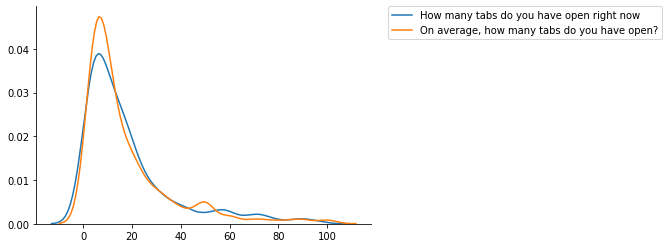

In [ ]:
sns.kdeplot(df.loc[df['How many tabs do you have open right now']<=100,'How many tabs do you have open right now'])
sns.kdeplot(df.loc[df['On average, how many tabs do you have open?']<=100,'On average, how many tabs do you have open?'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

In [ ]:
df['diff_from_avg'] = df['How many tabs do you have open right now'].sub(df['On average, how many tabs do you have open?'])

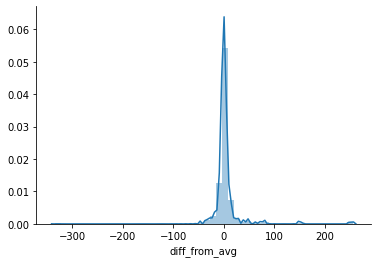

In [ ]:
sns.distplot(df.loc[:,'diff_from_avg'])
df.loc[:,['diff_from_avg']].describe()
sns.despine()
plt.show()

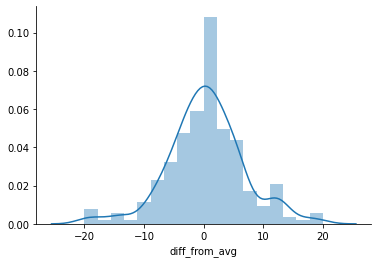

In [ ]:
sns.distplot(df.loc[df['diff_from_avg'].between(-20,20),'diff_from_avg'])
df.loc[df['diff_from_avg'].between(-20,20),['diff_from_avg']].describe()
sns.despine()
plt.show()

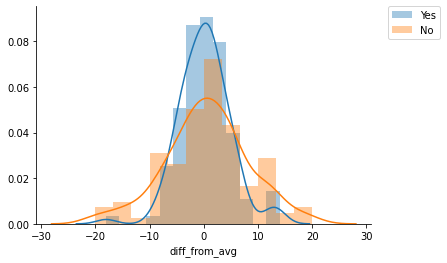

In [ ]:
sns.distplot(df.loc[(df['Do you believe people typically have more tabs open than you do?']==True)&(df['diff_from_avg'].between(-20,20)),'diff_from_avg'],label='Yes')
sns.distplot(df.loc[(df['Do you believe people typically have more tabs open than you do?']==False)&(df['diff_from_avg'].between(-20,20)),['diff_from_avg']],label='No')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
target = 'On average, how many tabs do you have open?'
ttdata = df.loc[df[target]<40]
a = ttdata.loc[ttdata['Do you believe people typically have more tabs open than you do?']==True,target]
b = ttdata.loc[ttdata['Do you believe people typically have more tabs open than you do?']==False,target]
ttest_ind(a,b)

Ttest_indResult(statistic=-7.151478445511592, pvalue=1.3113083318905284e-11)

In [ ]:
target = 'How many tabs do you have open right now'
ttdata = df.loc[df[target]<40]
a = ttdata.loc[ttdata['Do you believe people typically have more tabs open than you do?']==True,target]
b = ttdata.loc[ttdata['Do you believe people typically have more tabs open than you do?']==False,target]
ttest_ind(a,b)

Ttest_indResult(statistic=-6.490385547061043, pvalue=5.866737695023635e-10)

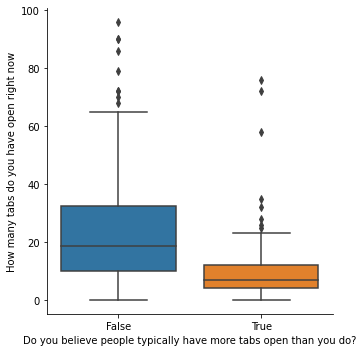

In [ ]:
sns.catplot(x='Do you believe people typically have more tabs open than you do?',y='How many tabs do you have open right now',data=df.loc[df['How many tabs do you have open right now']<100],kind='box')

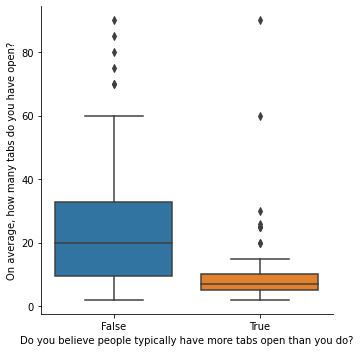

In [ ]:
sns.catplot(x='Do you believe people typically have more tabs open than you do?',y='On average, how many tabs do you have open?',data=df.loc[df['On average, how many tabs do you have open?']<100],kind='box')

## Who are these delusionals???
People who have >30 tabs open and think other people have _more_ tabs open than them is literally delusional based of the data. Who are they??

In [ ]:
_delusionals = df.loc[(df['Do you believe people typically have more tabs open than you do?']==True)&(df['How many tabs do you have open right now']>18)]
delusionals = df.loc[(df['Do you believe people typically have more tabs open than you do?']==False)&(df['How many tabs do you have open right now']<5)]
delusionals.append(_delusionals,ignore_index=True).shape

(23, 12)

count    263.000000
mean      30.585551
std        7.851150
min       18.000000
25%       25.000000
50%       29.000000
75%       35.000000
max       62.000000
Name: What is your age?, dtype: float64

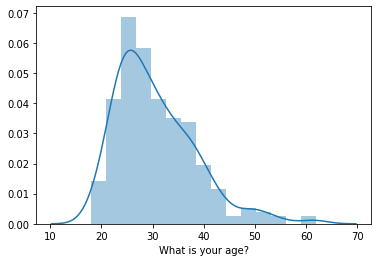

In [ ]:
sns.distplot(df['What is your age?'])
df['What is your age?'].describe()

count    11.000000
mean     27.636364
std       7.890155
min      19.000000
25%      22.000000
50%      24.000000
75%      32.000000
max      41.000000
Name: What is your age?, dtype: float64

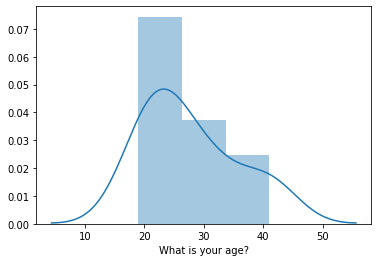

In [ ]:
sns.distplot(delusionals['What is your age?'])
delusionals['What is your age?'].describe()

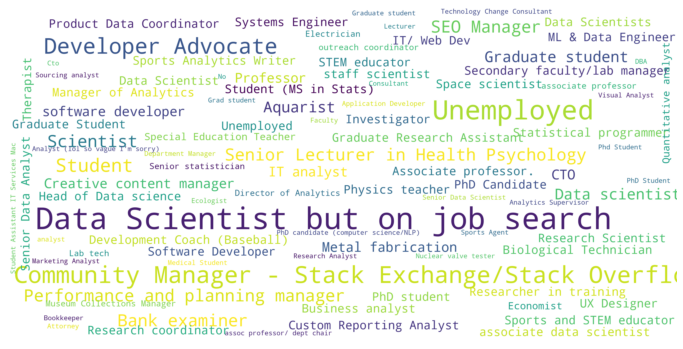

In [ ]:
wc_text = {row['What is your job title?']:row['On average, how many tabs do you have open?'] for idx, row in df.loc[:,['What is your job title?', 'On average, how many tabs do you have open?']].iterrows()}
wc = WordCloud(background_color="white", relative_scaling=0.4, scale=8)
wc.generate_from_frequencies(wc_text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

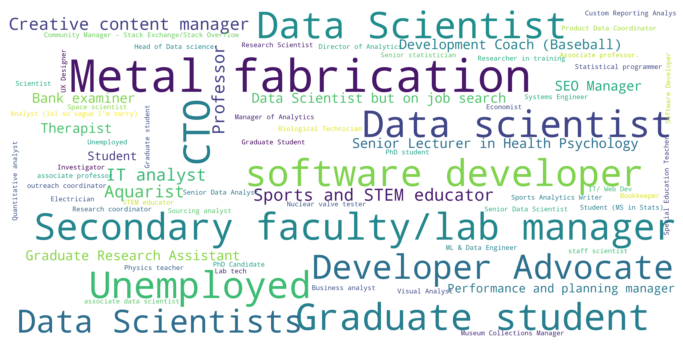

In [ ]:
wc_text = {row['What is your job title?']:row['On average, how many tabs do you have open?'] for idx, row in df.loc[:,['What is your job title?', 'On average, how many tabs do you have open?']].iterrows()}
for k,v in wc_text.items():
  if v>50:
    wc_text[k] = 50
wc = WordCloud(background_color="white", relative_scaling=.4, scale=8)
wc.generate_from_frequencies(wc_text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

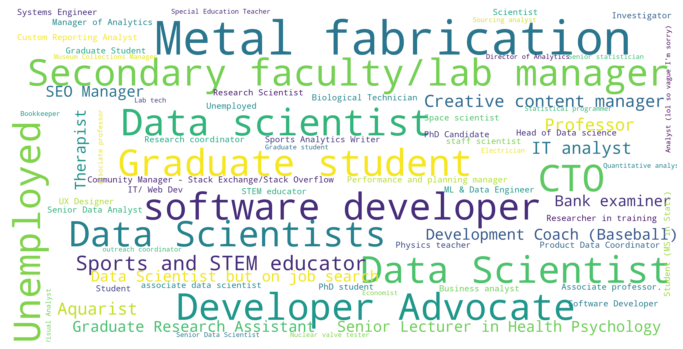

In [ ]:
wc_text = {row['What is your job title?']:row['On average, how many tabs do you have open?'] for idx, row in df.loc[:,['What is your job title?', 'On average, how many tabs do you have open?']].iterrows()}
for k,v in wc_text.items():
  if v>50:
    wc_text[k] = 50
wc = WordCloud(background_color="white", relative_scaling=0.6, scale=8)
wc.generate_from_frequencies(wc_text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

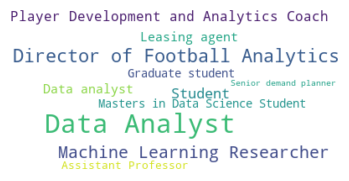

In [ ]:
wc_text = {row['What is your job title?']:row['On average, how many tabs do you have open?'] for idx, row in delusionals.loc[:,['What is your job title?', 'On average, how many tabs do you have open?']].iterrows()}
wc = WordCloud(background_color="white")
# generate word cloud
wc.generate_from_frequencies(wc_text)

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

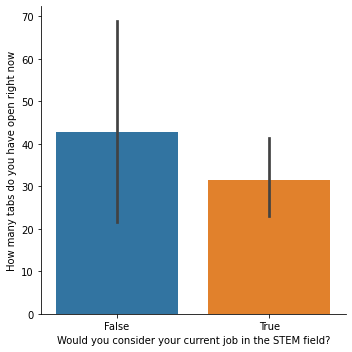

In [ ]:
sns.catplot('Would you consider your current job in the STEM field?','How many tabs do you have open right now',data=df,kind='bar')

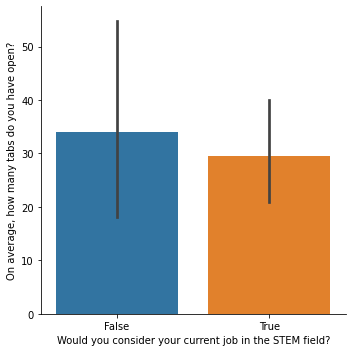

In [ ]:
sns.catplot('Would you consider your current job in the STEM field?','On average, how many tabs do you have open?',data=df,kind='bar')

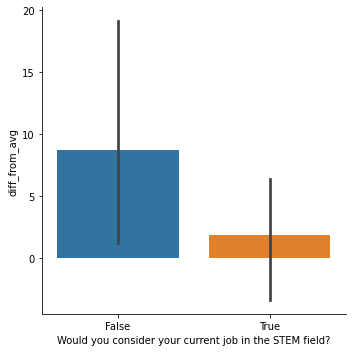

In [ ]:
sns.catplot('Would you consider your current job in the STEM field?','diff_from_avg',data=df,kind='bar')

In [ ]:
df.columns.values

array(['Timestamp',
       'How often do you work with data (organized values in something like a spreadsheet, CSV, database, etc)?',
       'How long have you been working with data?',
       'How many tabs do you have open right now',
       'On average, how many tabs do you have open?',
       'Do you believe people typically have more tabs open than you do?',
       'Would you consider your current job in the STEM field?',
       'What is your job title?', 'What is your age?',
       'How often do you work with data (organized values in something like a spreadsheet, CSV, database, etc)?_code',
       'How long have you been working with data?_code', 'diff_from_avg'],
      dtype=object)

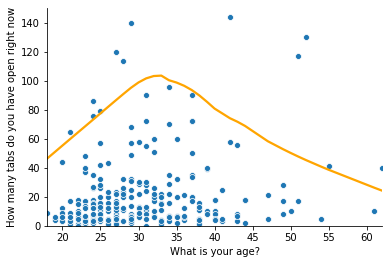

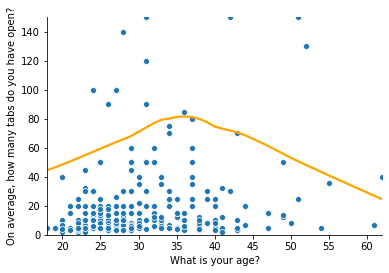

In [ ]:
x='What is your age?'
y='How many tabs do you have open right now'

df_quantile = pd.DataFrame()
for age in np.arange(18,65):
  _df_quantile = pd.DataFrame()
  try:
    _df_quantile[x] = [age]
    _df_quantile['q'] = df.loc[df[x]==age,y].quantile(.95)
    df_quantile = df_quantile.append(_df_quantile,ignore_index=True)
  except:
    continue

sns.scatterplot(x,y,data=df)
sns.regplot(x,'q',data=df_quantile,lowess=True,color='orange',scatter=False)
sns.despine()
plt.ylim(0,150)
plt.ylabel(y)
plt.show()

x='What is your age?'
y='On average, how many tabs do you have open?'

df_quantile = pd.DataFrame()
for age in np.arange(18,65):
  _df_quantile = pd.DataFrame()
  try:
    _df_quantile[x] = [age]
    _df_quantile['q'] = df.loc[df[x]==age,y].quantile(.95)
    df_quantile = df_quantile.append(_df_quantile,ignore_index=True)
  except:
    continue

sns.scatterplot(x,y,data=df)
sns.regplot(x,'q',data=df_quantile,lowess=True,color='orange',scatter=False)
sns.despine()
plt.ylim(0,150)
plt.ylabel(y)
plt.show()